In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pickle
import bisect
from numpy import random

# Landscape Plotting Functions

In [2]:
def interpolate(data_input, interpolation_function='linear'):
    """
    Transforms raw iterated simulation data into condensed data structure
    Maps interpolated scores onto dense mesh grid of traits (dp x pp)
    
    Interpolation functions :
    
    'linear': r
    'cubic': r**3
    'quintic': r**5
    'thin_plate': r**2 * log(r)
    'gaussian': exp(-(r/self.epsilon)**2)
    'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
    'multiquadric': sqrt((r/self.epsilon)**2 + 1)
    """
    # unpack data
    dps, pps, z_variable = data_input
    
    # convert into dictionary
    data_dict = {'drop_prob':dps, 
            'pickup_prob':pps, 
            'z_variable':z_variable}
    
    # output as 2D data structure via pandas DataFrame  
    df = pd.DataFrame(data_dict) 
    
    # align the repeated runs with same (dp x pp) + condense by averaging the scores
    means = df.groupby(['drop_prob', 'pickup_prob'], as_index=False)['z_variable'].mean()
    
    # set each data column to different axes
    x = means['pickup_prob']
    y = means['drop_prob']
    z = means['z_variable']
    
    # create mesh grid to map interpolation onto
    xi, yi = np.linspace(x.min(), x.max(), 101), np.linspace(y.min(), y.max(), 101)
    xi, yi = np.meshgrid(xi, yi)
    
    # interpolate the input dp x pp x score data
    rbf = scipy.interpolate.Rbf(x, y, z, function=interpolation_function)
    
    # map interpolation onto the mesh grid, creates a new estimated score for each grid position
    zi = rbf(xi, yi)
    
    return xi, yi, zi

In [3]:
def gradient_arrow_heatmap(interpolated_data, max_min, title, z_min=0, z_max=0,
                   normalize=True, vanishing_arrows=True, arrow_size=.5):
    """
    Calculates a mesh of arrows which shows direction and/or strength of gradient 
        along interpolated trait-score landscape
    Plots heatmap along with mesh with key design parameters:
    - normalize:
        - TRUE: arrows show direction only, gradient strength (arrow length) is equalized
    - vanishing_arrows:
        - TRUE: arrows with low gradient strength are displayed as dots
        - FALSE: arrows with low gradient strength are displayed as arrow heads
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # origins of arrows set to every 5 trait values in the middle of the grid (excluding 0, 100)
    a_min, a_max, a_stepsize = 5, 96, 5
    
    # discretizes interpolated data according to arrow origins
    xia = xi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    yia = yi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    zia = zi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    
    # finds gradient of the interpolated score arrow matrix
    yig, xig = np.gradient(zia)
    
    # plot background heatmap from interpolated data
    plot_heatmap(interpolated_data, max_min, title, z_min, z_max)
    
    # decision hierarchy which decides plot design
    # normalizing disregards gradient strength >> arrows are same length + only show direction
    # vanishing_arrows uses quiver() >> minimum length arrows plot as dots
    # non-vanishing_arrows uses arrow() + vectorize() >> minimum length arrows plot as arrow heads
    
    if normalize == True:
        dx = xig / np.sqrt(xig**2 + yig**2)
        dy = yig / np.sqrt(xig**2 + yig**2)
        
        plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
            
    else: # normalize: False
        dx, dy = xig, yig
        
        if vanishing_arrows == True:
            plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
        else: # vanishing_arrows: False
            vectorized_arrow_drawing = np.vectorize(func_to_vectorize)
            vectorized_arrow_drawing(xia, yia, dx, dy, 0.01 * arrow_size)

    plt.show()
    
def plot_heatmap(interpolated_data, max_min, title, z_min, z_max, cmap=plt.cm.gist_rainbow):
    """
    Plots heatmap of interpolated trait-score data
    Called within gradient_arrow_heatmap()
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # if no max score is defined, uses the maximum interpolated value
    if z_max == 0:
        z_max = round(np.amax(zi)/50)*50
    
    # sets up figure
    _, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlabel('Pickup Probability', fontsize=12)
    ax.set_ylabel('Drop Probability', fontsize=12)
    
    if title != 0:
        ax.set_title(title)
    
    # plots heatmap according to color scheme, bounded in the x/y/z directions
    hm = ax.imshow(zi, interpolation='none', cmap=cmap,
                extent=[xi.min(), xi.max(), yi.min(), yi.max()], origin=[0,0],
                vmin=z_min, vmax=z_max) 
    
    # adds color bar to the right side of heatmap
    cbar = plt.colorbar(hm)
    
    if max_min != 0:
        # pull max + min data
        dp_max, pp_max, z_max, dp_min, pp_min, z_min = max_min

        plt.plot(pp_max,dp_max,'ro')
        plt.plot(pp_min,dp_min,'bo')
        
def func_to_vectorize(x, y, dx, dy, scaling):
    """
    Used for plotting gradient arrows in conjunction with vectorize()
    Called within gradient_arrow_heatmap()
    """
    plt.arrow(x, y, dx*scaling, dy*scaling, fc="k", ec="k", head_width=1.5, head_length=1)

In [4]:
def linear_cost(data_nocost, max_cost, apply_pp_cost=True, apply_dp_cost=True, plot_cost=False):
    """
    Scales score by relative trait values of either/or dp + pp, bounded by max_cost
    Output mirrors the pull_data functions (3 lists)
    """
    dps = []
    pps = []
    scaled_scores = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in data_nocost:
        pp_cost = pp/100 * max_cost * apply_pp_cost
        dp_cost = dp/100 * max_cost * apply_dp_cost
        # score proportionally decreased by higher pp and/or dp trait values
        scaled_score = t_score[-1]*(1 - pp_cost - dp_cost)
        # builds lists
        dps.append(dp)
        pps.append(pp)
        scaled_scores.append(scaled_score)
    
    # plots cost function if called
    if plot_cost == True:
        x = np.linspace(0, 100, 101)
        y = x/100 * max_cost
        fig = plt.figure(figsize = (10, 5))
        plt.plot(x, y)
    
    return dps, pps, scaled_scores

# Evolution Functions: 
# Selection/Mutation/Generational Looping

In [5]:
def interpolation_dictionary(interpolated_data):
    """
    Dissolve interpolation matrix into referenceable dictionary
    where a tuple of traits calls its related score
    """
    pp_int, dp_int, score_int = interpolated_data
    
    traits_to_score = {}
    
    # for each trait value combination, add "(dp, pp): score" to the dictionary
    for x in range(101):
        for y in range(101):
            traits_to_score[ (pp_int[x,y] , dp_int[x,y]) ] = score_int[x,y]
            
    return traits_to_score

In [6]:
# gather data to be used for the following examples
master_data = pickle.load(open('landscape_data_dplen10_ant25_spacing5_rep10_step1K','rb'))
data_cost = linear_cost(master_data, 0.3, apply_pp_cost=True, apply_dp_cost=False, plot_cost=False)
interp_data_cost = interpolate(data_cost, 'linear')

traits_to_score = interpolation_dictionary(interp_data_cost)
traits_to_score

{(0.0, 0.0): 545.2999999999975,
 (1.0, 0.0): 543.6741234523129,
 (2.0, 0.0): 541.9557800868581,
 (3.0, 0.0): 540.0866525740382,
 (4.0, 0.0): 538.0021818599005,
 (5.0, 0.0): 535.6429999999966,
 (6.0, 0.0): 534.6077650397478,
 (7.0, 0.0): 533.2427758593376,
 (8.0, 0.0): 531.5552725745188,
 (9.0, 0.0): 529.5640215105643,
 (10.0, 0.0): 527.2920000000033,
 (11.0, 0.0): 526.5096565041251,
 (12.0, 0.0): 525.5001312784991,
 (13.0, 0.0): 524.2951579543446,
 (14.0, 0.0): 522.9281355859773,
 (15.0, 0.0): 521.4300000000044,
 (16.0, 0.0): 520.0470760154578,
 (17.0, 0.0): 518.5701450322726,
 (18.0, 0.0): 517.0050898758793,
 (19.0, 0.0): 515.3538577583342,
 (20.0, 0.0): 513.6160000000025,
 (21.0, 0.0): 511.8360262918152,
 (22.0, 0.0): 509.95574945780436,
 (23.0, 0.0): 507.9611329842305,
 (24.0, 0.0): 505.8367068780053,
 (25.0, 0.0): 503.57000000000335,
 (26.0, 0.0): 502.2245403571303,
 (27.0, 0.0): 500.73499231758115,
 (28.0, 0.0): 499.11064598827306,
 (29.0, 0.0): 497.36167317686227,
 (30.0, 0.0): 4

In [7]:
def interpolation_range_extract(interpolated_data):
    """
    Extract interpolated trait value range to allow bisection
    Each trait value range is idential, only outputs interpolation range for first trait
    """
    pp_int, dp_int, score_int = interpolated_data
    
    # pp projects along the array rows, dp along the columns
    interp_range = pp_int[0,:]
#     interp_range = dp_int[:,0]
    
    return interp_range

In [8]:
interp_range = interpolation_range_extract(interp_data_cost)
interp_range

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100.])

In [9]:
def interpolated_range_slice(interp_range, lo_lim, hi_lim):
    """
    Slice interpolation data to allow colony selection within defined ranges
    """
    # bisect returns the leftmost + rightmost place in the interpolated trait value range
    lo_lim_interp = bisect.bisect_left(interp_range, lo_lim)
    hi_lim_interp = bisect.bisect_right(interp_range, hi_lim)
    
    return interp_range[lo_lim_interp:hi_lim_interp]

In [10]:
interpolated_range_slice(interp_range, 5, 20)

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20.])

In [11]:
def initialize(num_colonies, interp_range, pp_lo_lim, pp_hi_lim, dp_lo_lim, dp_hi_lim):
    """
    Randomly choose trait tuples for specified number of colonies within lo/hi limits
    """
    col_traits = []
    
    # choose trait values randomly in each interpolated/bounded trait range
    for colony in range(num_colonies):
        pp = random.choice(interpolated_range_slice(interp_range, pp_lo_lim, pp_hi_lim))
        dp = random.choice(interpolated_range_slice(interp_range, dp_lo_lim, dp_hi_lim))
        
        col_traits.append( (pp, dp) )
        
    return col_traits

In [12]:
num_colonies = 10
pp_lo_lim = 80
pp_hi_lim = 100
dp_lo_lim = 0
dp_hi_lim = 20

col_traits = initialize(num_colonies, interp_range, pp_lo_lim, pp_hi_lim, dp_lo_lim, dp_hi_lim)
col_traits

[(98.0, 12.0),
 (85.0, 0.0),
 (97.0, 11.0),
 (83.0, 2.0),
 (88.0, 4.0),
 (99.0, 18.0),
 (91.0, 16.0),
 (93.0, 13.0),
 (97.0, 11.0),
 (81.0, 5.0)]

In [13]:
def find_fitness(col_traits,traits_to_score):
    """
    Use dictionary to look up scores for each colony's trait tuple
    Report traits/score (fitness) of each and total fitness for all colonies in the generation
    """
    col_traits_fitnesses = []
    fitness_sum = 0

    # use each trait tuple to find related score in traits_to_score dictionary
    for traits in col_traits:
        fitness = traits_to_score[traits]
        fitness_sum += fitness
        col_traits_fitnesses.append(traits+(fitness,))
    
    # sort trait/score list by the scores in ascending order
    col_traits_fitnesses_sorted = sorted(col_traits_fitnesses, key=lambda x: x[2])
    
    return col_traits_fitnesses_sorted, fitness_sum

In [14]:
col_traits_fitnesses_sorted, fitness_sum = find_fitness(col_traits,traits_to_score)
col_traits_fitnesses_sorted, fitness_sum

([(98.0, 12.0, 393.4742933961204),
  (97.0, 11.0, 394.1625772231905),
  (97.0, 11.0, 394.1625772231905),
  (99.0, 18.0, 397.5761837386153),
  (93.0, 13.0, 403.5986511129797),
  (88.0, 4.0, 403.97949930031587),
  (85.0, 0.0, 407.29150000000277),
  (91.0, 16.0, 411.5128837950758),
  (83.0, 2.0, 411.5587618394359),
  (81.0, 5.0, 417.762179546123)],
 4035.07910717505)

In [15]:
def calc_breeding_prob(col_traits_fitnesses_sorted, fitness_sum):
    """
    Normalize fitnesses relative to the total fitness, where adding each will equal 1
    Construct line of relative fitnesses to function as breeding probabilities
    Builds the wheel for Roulette Wheel Selection
    """
    breeding_probs = [0]
    
    # calculate ratio of fitness:total fitness for each colony, add to previous, append
    for colony in range(len(col_traits_fitnesses_sorted)):
        breeding_prob = col_traits_fitnesses_sorted[colony][2] / fitness_sum + breeding_probs[colony]
        breeding_probs.append(breeding_prob)
    
    return breeding_probs

In [16]:
breeding_probs = calc_breeding_prob(col_traits_fitnesses_sorted, fitness_sum)
breeding_probs

[0,
 0.09751340257405533,
 0.19519738019974875,
 0.29288135782544217,
 0.3914113180018506,
 0.49143380588698604,
 0.5915506780895587,
 0.6924883522173769,
 0.7944721976055222,
 0.8964674127941452,
 0.9999999999999999]

In [17]:
def select_parents(num_parents, breeding_probs, col_traits_fitnesses_sorted):
    """
    Generate random numbers (0-1) and correlate to the breeding probability line 
    to select which colonies (trait tuples) survive to the next generation
    """
    selected_col_traits = []
    
    for parent in range(num_parents):
        rand_num = random.random()
        
        # scroll along breeding probability line,
        # if the random number is greater than the breeding probability,
        # return the corresponding traits
        for i in range(len(breeding_probs)+1):
            if rand_num < breeding_probs[i]:
                selected_col_traits.append(col_traits_fitnesses_sorted[i-1][0:2])
                break
    
    return selected_col_traits

In [18]:
num_parents = 10
selected_col_traits = select_parents(num_parents, breeding_probs, col_traits_fitnesses_sorted)
selected_col_traits

[(91.0, 16.0),
 (81.0, 5.0),
 (88.0, 4.0),
 (97.0, 11.0),
 (91.0, 16.0),
 (98.0, 12.0),
 (99.0, 18.0),
 (93.0, 13.0),
 (98.0, 12.0),
 (91.0, 16.0)]

In [19]:
def breed_offspring(selected_col_traits):
    """
    Mate pairs of parents, producing two offspring for each pair
    Each trait has 50% probability of being passed for each mating
    No genetic crossover implemented
    """
    pp_offspring = []
    dp_offspring = []
    
    # extract pp's + dp's for each two parents, randomly choose, append/zip as offspring trait tuples
    for pair in range(int(len(selected_col_traits)/2)):
        for i in range(2):
            pp_pair = (selected_col_traits[2*pair][0], selected_col_traits[2*pair+1][0])
            dp_pair = (selected_col_traits[2*pair][1], selected_col_traits[2*pair+1][1])
            
            pp_offspring.append(random.choice(pp_pair))
            dp_offspring.append(random.choice(dp_pair))
    
    offspring_traits = list(zip(pp_offspring,dp_offspring))
    
    return offspring_traits

In [20]:
offspring_traits = breed_offspring(selected_col_traits)
offspring_traits

[(91.0, 5.0),
 (91.0, 16.0),
 (97.0, 11.0),
 (97.0, 11.0),
 (98.0, 16.0),
 (98.0, 12.0),
 (99.0, 13.0),
 (93.0, 18.0),
 (91.0, 16.0),
 (91.0, 16.0)]

In [21]:
def choose_trait_normal(trait_value, std_dev):
    """
    Choose mutated trait value from normal distribution
    centered around trait_value (mu = trait_value) 
    with a specified standard deviation (sigma = std_dev)
    truncated to the 0-100 trait value range
    """
    # picks trait value from normal distribution
    trait = np.random.normal(trait_value, std_dev)
    
    # only allows trait values within the 0-100 range
    while trait < 0 or trait > 100:
        trait = np.random.normal(trait_value, std_dev)
    
    # returns an integer to correlate with the interpolated range
    return int(trait)

1 x standard deviation:  9.97
0.1% chance for trait to shift +/- 29.9


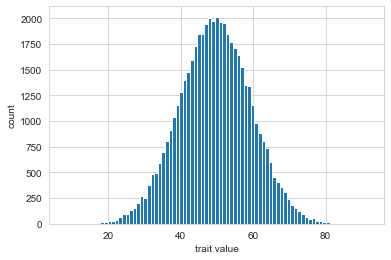

In [22]:
# demonstrates results of chose_trait_normal + plots as a histogram
trait_value = 50
std_dev = 10

mutated_traits = []
for i in range(50000):
    trait = choose_trait_normal(trait_value,std_dev)
    mutated_traits.append(int(trait))

# calculate/print resulting standard deviation
print('1 x standard deviation: ', round(np.std(mutated_traits),2))
print('0.1% chance for trait to shift +/-', round(np.std(mutated_traits)*3,2))

plt.hist(mutated_traits,bins=int(max(mutated_traits)-min(mutated_traits))+1)
plt.xlabel('trait value')
plt.ylabel('count');

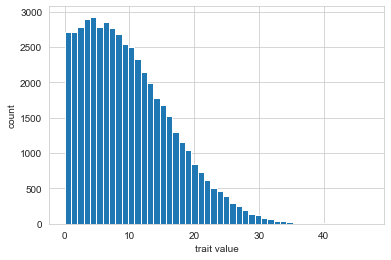

In [23]:
# to illustrate behavior at truncation limit
trait_value = 5
std_dev = 10

mutated_traits = []
for i in range(50000):
    trait = choose_trait_normal(trait_value,std_dev)
    mutated_traits.append(int(trait))

plt.hist(mutated_traits,bins=int(max(mutated_traits)-min(mutated_traits))+1)
plt.xlabel('trait value')
plt.ylabel('count');

In [24]:
def mutate(mutation_probability, mutation_std_dev, offspring_traits):
    """
    Decide whether to mutate each trait according to a mutation_probability
    Use choose_trait_truncnorm() to pick mutated trait value from a truncated normal distribution
    """
    offspring_traits_after_mutation = []
    
    for i in range(len(offspring_traits)):
        traits_after_mutation = []
        pp = offspring_traits[i][0]
        dp = offspring_traits[i][1]
        
        # random number to decide whether to mutate each trait
        if random.random() < mutation_probability:
            mutated_pp = choose_trait_normal(pp, mutation_std_dev)
            traits_after_mutation.append(mutated_pp)
        else: # if mutation is not chosen, append non-mutated trait value
            traits_after_mutation.append(pp)

        if random.random() < mutation_probability:
            mutated_dp = choose_trait_normal(dp, mutation_std_dev)
            traits_after_mutation.append(mutated_dp)
        else:
            traits_after_mutation.append(dp)
        
        # append traits, whether mutated or not, as tuple to output list
        offspring_traits_after_mutation.append(tuple(traits_after_mutation))
    
    return offspring_traits_after_mutation

In [25]:
mutation_probability = 1
mutation_std_dev = 5

offspring_traits_after_mutation = mutate(mutation_probability, mutation_std_dev, offspring_traits)
offspring_traits, offspring_traits_after_mutation

([(91.0, 5.0),
  (91.0, 16.0),
  (97.0, 11.0),
  (97.0, 11.0),
  (98.0, 16.0),
  (98.0, 12.0),
  (99.0, 13.0),
  (93.0, 18.0),
  (91.0, 16.0),
  (91.0, 16.0)],
 [(88, 11),
  (91, 16),
  (90, 14),
  (97, 21),
  (97, 16),
  (98, 12),
  (96, 12),
  (95, 25),
  (97, 19),
  (96, 16)])

In [26]:
def outer_evol_loop(num_evolutions, num_col, interp_range, pp_lo_lim, pp_hi_lim, dp_lo_lim, dp_hi_lim,
                    traits_to_score, num_gen_save, num_gen_overall, m_prob, m_std_dev):
    """
    Run multiple evolutions of ant colony traits (pp, dp), each of which involves:
        Initialize evolutionary pool containing colonies of randomly generated trait values
        Run inner loop which evolves the colonies a certain number of generations
        Log trait + score data after each loop until completion
    """
    
    overall_evol_log = []
    for evol in range(num_evolutions):
        # start each evolution by generating traits + calculating fitnesses for each colony
        col_traits = initialize(num_col, interp_range, pp_lo_lim, pp_hi_lim, dp_lo_lim, dp_hi_lim)  
        col_traitfitness_init, fitness_sum = find_fitness(col_traits,traits_to_score)
        # start data log with initial trait/fitness information
        evol_data = [col_traitfitness_init]

        # run a selection-breeding-mutation loop for a specified number of generations (num_gen_save)
        # save trait/fitness info between each inner loop, iterate until end (num_gen_overall)
        for gen_save in range(num_gen_save,num_gen_overall+1,num_gen_save):
            col_traits, col_traitfitness = inner_evol_loop(num_gen_save, col_traits, traits_to_score, 
                                                          num_col, m_prob, m_std_dev)
            evol_data.append(col_traitfitness)

        # append log of each evolution to overall log
        overall_evol_log.append(evol_data)
        
    return overall_evol_log

In [27]:
def inner_evol_loop(num_generations, col_traits, traits_to_score, 
                  num_col, m_prob, m_std_dev):
    """
    Select + breed + mutate a list of ant colony traits (pp, dp), involving:
        Selection via roulette wheel (fitness proportionate) methodology
        Breeding involves random parent pairs producing 2 offspring with 50% chance of trait passage
        Mutation via binomial distribution with specified occurance probability + standard deviation
    """
    
    for gen in range(num_generations):
        # look up fitness, sort list, calculate sum
        col_traitfitness, fitness_sum = find_fitness(col_traits, traits_to_score)
        # calculate the breeding probability line for roulette wheel selection
        breeding_probs = calc_breeding_prob(col_traitfitness, fitness_sum)
        # select which colonies will breed
        selected_col_traits = select_parents(num_col, breeding_probs, col_traitfitness)
        # breed parents to produce offspring
        offspring_traits = breed_offspring(selected_col_traits)
        # mutate the offspring
        # rename the output of this function to fit the input of the next loop
        col_traits = mutate(m_prob, m_std_dev, offspring_traits)
    
    # look up fitness
    col_traitfitness, fitness_sum = find_fitness(col_traits, traits_to_score)
    
    # output col_traits to serve as input for the next loop + col_traitfitness to log generation data
    return col_traits, col_traitfitness

# Evolution Plotting Functions

In [28]:
def evolutionary_heatmap(interpolated_data, overall_evol_log, title, z_max=0):
    """
    Plots heatmap with corresponding evolutionary trajectories where
    the colony trait values of each generation (inner_evol_loop) of each evolution (outer_evol_loop)
    are averaged and plotted as white trajectories and final values are plotted as black points
    """    
    # plot background heatmap from interpolated data
    plot_heatmap(interpolated_data, max_min=0, title=title, z_min=0, z_max=z_max)
    
    # unpack each evolution (outer loop) in data log
    final_pts = []
    for evol in overall_evol_log:
        
        # calculate mean (pp, dp) traits for each generation of the evolution
        gen_avgs = []
        for gen in evol:
            gen_avgs.append(average_traits_of_population(gen))
            
        # extract individual trait trajectories across evolution, plot as thin white lines
        pp_gen_avg = [element[0] for element in gen_avgs]
        dp_gen_avg = [element[1] for element in gen_avgs]
        plt.plot(pp_gen_avg, dp_gen_avg, 'white', linewidth=.5, zorder=1)
        
        # send the final mean trait data of each evolution to a separate list
        final_pts.append(gen_avgs[-1])

    # plot final mean traits as black points in front of the white trajectories
    for pp_final, dp_final in final_pts:
        plt.scatter(pp_final, dp_final, s=20, c='black', zorder=2)

    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.show()
    
    # return list of final mean traits for further analysis
    return final_pts

In [29]:
def average_traits_of_population(pop_data):
    """
    Split (pp, dp) data list, calculate/return overall mean values of each trait list
    """
    dps = [element[0] for element in pop_data]
    pps = [element[1] for element in pop_data]
    return sum(dps)/len(dps), sum(pps)/len(pps)

In [30]:
def task_partitioning_plot(overall_evol_log, title=0, save=0):
    """
    Plots evolutionary trajectories by combining trait values (dp, pp) into a single value:
        degree of task partitioning where:
            0 represents a fully generalist strategy: no leaves are dropped
            100 represents a fully task partitioned colony: no leaves are carried down the tree
    """
    fig = plt.subplots(figsize=(12, 8))

    # unpack each evolution (outer loop) in data log
    for evol in overall_evol_log:

        # calculate mean (pp, dp) traits for each generation of the evolution
        gen_avgs = []
        for gen in evol:
            gen_avgs.append(average_traits_of_population(gen))

        # extract individual trait trajectories across evolution, plot as thin white lines
        pp_gen_avg = [element[0] for element in gen_avgs]
        dp_gen_avg = [element[1] for element in gen_avgs]

        # combine/average pp + dp trait values to 'degree of task partitioning'
        degTP = [np.average([pp,dp]) for pp,dp in zip(pp_gen_avg, dp_gen_avg)]

        # plot degree of task partitioning 
        plt.plot(range(len(evol)), degTP, linewidth=.5, color='k')

    plt.ylim(0,100)
    plt.xlim(0,len(evol)-1)
    plt.ylabel('Degree of Task Partitioning')
    plt.xlabel('Time (1 = 100 Generations)')
    
    if title != 0:
        plt.title(title)
    
    if save == 0:
        plt.show()
    else:
        plt.savefig(save,dpi=400)
        plt.show()
        
    plt.show()

# Evolutionary Run

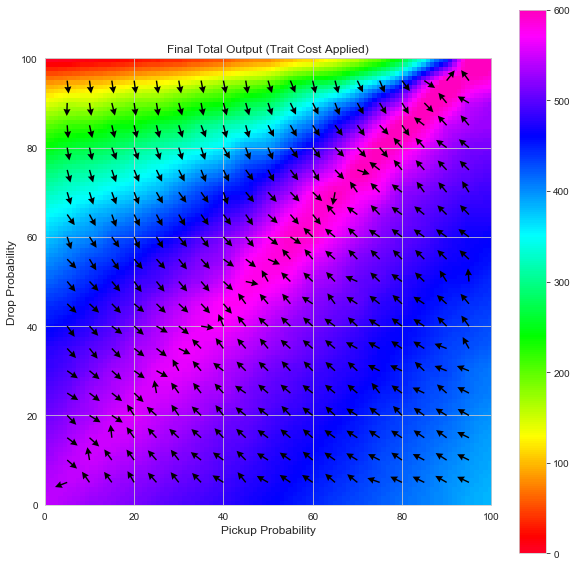

In [31]:
"""
plot final total output + trait cost heatmap, to be used in evolutionary trajectory plot below
generate traits_to_score + interp_range from interpolated data matrices
"""

hm_title = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
master_data = pickle.load(open(hm_title,'rb'))

plot_max = 600

data_cost = linear_cost(master_data, 0.3, apply_pp_cost=True, apply_dp_cost=False, plot_cost=False)
interp_data_cost = interpolate(data_cost, 'linear')
gradient_arrow_heatmap(interp_data_cost, max_min=0, 
    title=f'Final Total Output (Trait Cost Applied)', 
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

traits_to_score = interpolation_dictionary(interp_data_cost)
interp_range = interpolation_range_extract(interp_data_cost)

In [32]:
# specify evolutionary run parameters
num_evolutions = 100

num_gen_overall = 10000
num_gen_save = 100

num_col = 50

pp_lo_lim = 0
pp_hi_lim = 20
dp_lo_lim = 0
dp_hi_lim = 20

m_prob = .01
m_std_dev = 10

In [ ]:
# run evolutionary algorithm
evol_data = outer_evol_loop(
    num_evolutions, num_col, interp_range, pp_lo_lim, pp_hi_lim, dp_lo_lim, dp_hi_lim,
    traits_to_score, num_gen_save, num_gen_overall, m_prob, m_std_dev
)

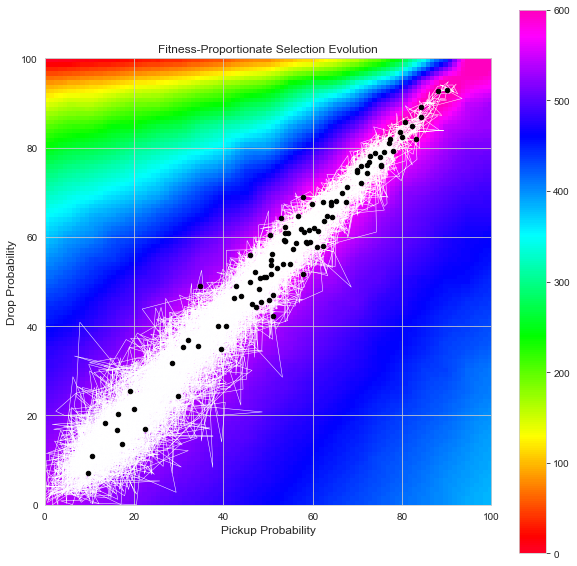

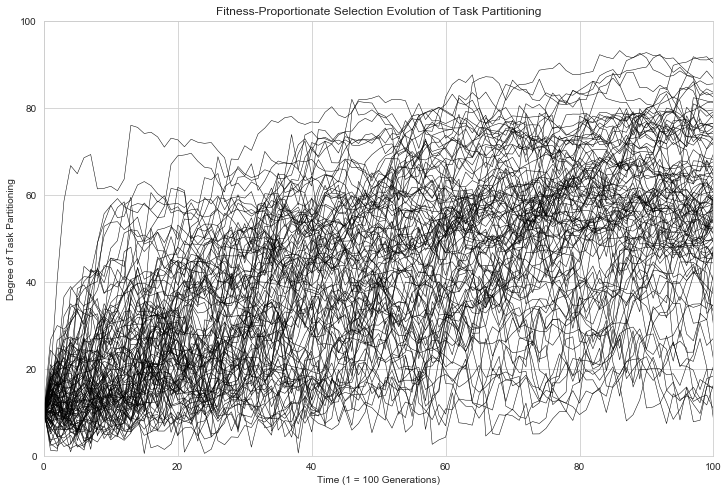

In [33]:
evol_title = 'evol_data_dplen10_gen10k_col50_mrange100'
evol_data = pickle.load(open(evol_title,'rb'))

# plot evolutionary trajectories over the fitness landscape heatmap
final_pts = evolutionary_heatmap(interp_data_cost, evol_data, z_max=plot_max,
            title=f'Fitness-Proportionate Selection Evolution')

# plot evolutionary trajectories as progression towards a fully task-partitioned state
task_partitioning_plot(evol_data,
            title=f'Fitness-Proportionate Selection Evolution of Task Partitioning')